# Multi-Task Learning Notebook 

`I hope this is the last iteration`

We are going to import three datasets:
1. Children’s fairy tales (1000-100-100, ekman categorical)
2. Emobank (9000-300-300, vad regression)
3. SemEval-2018 (~7k - 1k - 3k, multi-label)

# Install & imports

In [2]:
!pip install transformers -q
!pip install wandb -q
!pip install -Uqq ipdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.3/793.3 KB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.8/385.8 KB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython~=7.9.0, but you have ipython 8.11.0 which is incompatible.


In [6]:
import torch 
import torch.nn as nn
import transformers
import pdb
import wandb
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import ones_like, zeros_like

import os
import math
import copy
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.notebook import tqdm

from transformers import AutoModel, BertTokenizerFast

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

# set manual seed 
np.random.seed(42)
torch.manual_seed(42)

cuda:0


## Give Access

In [12]:
from google.colab import drive
drive.mount('/content/drive')

wandb.login()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


True

## Import dataset from github

In [14]:
!git clone https://github.com/LeonY117/EmotionAnalysis.git -q

# Read and process data

### Fairy Tale dataset & Emobank

In [15]:
# load the cleaned up dataset from github
CLEAN_DATA_DIR = "/content/EmotionAnalysis/data/clean/"
CHILDREN_filename = "children_highAgree.csv"
EMOBANK_filename = "emobank.csv"

df_children = pd.read_csv(os.path.join(CLEAN_DATA_DIR, CHILDREN_filename))
df_emobank = pd.read_csv(os.path.join(CLEAN_DATA_DIR, EMOBANK_filename))

print(f'Children story dataset: {len(df_children)}')
print(f'Emobank dataset: {len(df_emobank)}')
print(df_children.head())
print(df_emobank.head())

Children story dataset: 1207
Emobank dataset: 9814
   Unnamed: 0                                           sentence  label
0           0  He looked around on every side and exclaimed, ...      4
1           1  Then he got up and clambered out of the cave, ...      3
2           2                    "Alas, thou canst not help me."      3
3           3  They leapt nimbly upstairs and downstairs, and...      2
4           4  Then she opened the door of the small house, a...      2
                    id  split     V     A     D  \
0  110CYL068_1036_1079  train  3.00  3.00  3.20   
1  110CYL068_1079_1110   test  2.80  3.10  2.80   
2  110CYL068_1127_1130  train  3.00  3.00  3.00   
3  110CYL068_1137_1188  train  3.44  3.00  3.22   
4  110CYL068_1189_1328  train  3.55  3.27  3.46   

                                                text  
0        Remember what she said in my last letter? "  
1                          If I wasn't working here.  
2                                            

### Sem-Eval Dataset

Which already has train-val-test split

In [16]:
sem_train_filename = "SemEval2018_train.csv"
sem_val_filename = "SemEval2018_val.csv"
sem_test_filename = "SemEval2018_test.csv"

df_sem_train = pd.read_csv(os.path.join(CLEAN_DATA_DIR, sem_train_filename))
df_sem_val = pd.read_csv(os.path.join(CLEAN_DATA_DIR, sem_val_filename))
df_sem_test = pd.read_csv(os.path.join(CLEAN_DATA_DIR, sem_test_filename))

df_sem_train.head()

,text,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


## Define Global Variables

In [17]:
EKMAN_EMOTIONS = ['anger-disgust', 'fear', 'happy', 'sad', 'surprise']
SEM_EMOTIONS = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
VAD_EMOTIONS = ['V', 'A', 'D']

# outputs heads (prediction heads)
NUM_CLASSES_EKMAN = len(EKMAN_EMOTIONS) # 5
NUM_CLASSES_SEM = len(SEM_EMOTIONS) # 11
NUM_CLASSES_VAD = len(VAD_EMOTIONS) # 3

OUT_DIMS = {
    'ekman': NUM_CLASSES_EKMAN, 'vad': NUM_CLASSES_VAD, 'sem': NUM_CLASSES_SEM
}

# label lengths (this is how many slots it takes to store the labels)
Y_DIM_EKMAN = 1
Y_DIM_VAD = NUM_CLASSES_VAD
Y_DIM_SEM = NUM_CLASSES_SEM

Y_DIMS = {
    'ekman': Y_DIM_EKMAN, 'vad': Y_DIM_VAD, 'sem': Y_DIM_SEM
}

## Load data from table to numpy array

In [18]:
# Load data into numpy
x_ekman_raw = list(df_children['sentence'])
y_ekman_raw = df_children['label'].to_numpy()

x_vad_raw = list(df_emobank['text'])
y_vad_raw = df_emobank[VAD_EMOTIONS].to_numpy()

x_sem_train_raw = list(df_sem_train['text'])
y_sem_train_raw = df_sem_train[SEM_EMOTIONS].to_numpy()

x_sem_val_raw = list(df_sem_val['text'])
y_sem_val_raw = df_sem_val[SEM_EMOTIONS].to_numpy()

x_sem_test_raw = list(df_sem_test['text'])
y_sem_test_raw = df_sem_test[SEM_EMOTIONS].to_numpy()

# Example:
print(x_ekman_raw[0])
print(y_ekman_raw[0])

print(x_vad_raw[0])
print(y_vad_raw[0])

print(x_sem_train_raw[0])
print(y_sem_train_raw[0])

He looked around on every side and exclaimed, "Oh, heavens, where am I?"
4
Remember what she said in my last letter? "
[3.  3.  3.2]
“Worry is a down payment on a problem you may never have'.  Joyce Meyer.  #motivation #leadership #worry
[0 1 0 0 0 0 1 0 0 0 1]


## Download Bert and tokenizer

In [19]:
# Load the BERT tokenizer
pretrained_checkpoint = 'bert-base-uncased' 

tokenizer = BertTokenizerFast.from_pretrained(pretrained_checkpoint)

# import BERT-base pretrained model
bert = AutoModel.from_pretrained(pretrained_checkpoint)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
# Move bert to GPU
for param in bert.parameters():
  param.requires_grad = False
bert.to(DEVICE)
print(f'moved bert to {DEVICE}')

moved bert to cuda:0


### Preprocess with Tokenizer

In [21]:
tokenized_xs = {}

encoded_input = tokenizer(x_ekman_raw, padding=True, truncation=True, return_tensors="pt")
X_ekman_input = encoded_input['input_ids']
X_ekman_mask = encoded_input['attention_mask']
tokenized_xs['ekman'] = [X_ekman_input, X_ekman_mask]

encoded_input = tokenizer(x_vad_raw, padding=True, truncation=True, return_tensors="pt")
X_vad_input = encoded_input['input_ids']
X_vad_mask = encoded_input['attention_mask']
tokenized_xs['vad'] = [X_vad_input, X_vad_mask]

encoded_input = tokenizer(x_sem_train_raw, padding=True, truncation=True, return_tensors="pt")
X_input = encoded_input['input_ids']
X_mask = encoded_input['attention_mask']
tokenized_xs['sem_train'] = [X_input, X_mask]

encoded_input = tokenizer(x_sem_val_raw, padding=True, truncation=True, return_tensors="pt")
X_input = encoded_input['input_ids']
X_mask = encoded_input['attention_mask']
tokenized_xs['sem_val'] = [X_input, X_mask]

encoded_input = tokenizer(x_sem_test_raw, padding=True, truncation=True, return_tensors="pt")
X_input = encoded_input['input_ids']
X_mask = encoded_input['attention_mask']
tokenized_xs['sem_test'] = [X_input, X_mask]

### Preprocess with BERT

In [22]:
BERT_OUT_SIZE = 768
preprocessed_xs = {}

for name, X in tokenized_xs.items():
  # allocate memory
  n = X[0].shape[0]
  preprocessed_xs[name] = torch.empty(size=(n, BERT_OUT_SIZE), dtype=torch.float)

  # use minibatch to process data
  b = 100
  num_batches = math.ceil(n // b)

  print(f'Preprocessing {name}...')
  for i in tqdm(range(num_batches)):
    x_ids = X[0][i*b: (i+1)*b].to(DEVICE)
    x_masks = X[1][i*b: (i+1)*b].to(DEVICE)

    output = bert(x_ids, attention_mask=x_masks)

    hidden_state = output['last_hidden_state']
    pooler_output = output['pooler_output']
    
    preprocessed_xs[name][i*b: (i+1)*b] = pooler_output

Preprocessing ekman...


  0%|          | 0/12 [00:00<?, ?it/s]

Preprocessing vad...


  0%|          | 0/98 [00:00<?, ?it/s]

Preprocessing sem_train...


  0%|          | 0/68 [00:00<?, ?it/s]

Preprocessing sem_val...


  0%|          | 0/8 [00:00<?, ?it/s]

Preprocessing sem_test...


  0%|          | 0/32 [00:00<?, ?it/s]

### Preprocess labels 
All labels need to be the same length, and we pad with 0s

In [23]:
preprocessed_ys = {}

# create placeholder tensors
ekman_zeros = torch.zeros((1, Y_DIMS['ekman']), )
vad_zeros = torch.zeros((1, Y_DIMS['vad']), )
sem_zeros = torch.zeros((1, Y_DIMS['sem']), )

# EKMAN
y = torch.tensor(y_ekman_raw, dtype=torch.float).unsqueeze(-1)
n = y.shape[0]
y = torch.concatenate((y, vad_zeros.repeat(n, 1), sem_zeros.repeat(n, 1)), dim=-1)
preprocessed_ys['ekman'] = y

# VAD
y = torch.tensor(y_vad_raw, dtype=torch.float)
n = y.shape[0]
y = torch.concatenate((ekman_zeros.repeat(n, 1), y, sem_zeros.repeat(n, 1)), dim=-1)

# normalize vad
y = F.normalize(y, dim=-1)
preprocessed_ys['vad'] = y

# sem
y = torch.tensor(y_sem_train_raw, dtype=torch.float)
n = y.shape[0]
y = torch.concatenate((ekman_zeros.repeat(n, 1), vad_zeros.repeat(n, 1), y), dim=-1)
preprocessed_ys['sem_train'] = y

y = torch.tensor(y_sem_val_raw, dtype=torch.float)
n = y.shape[0]
y = torch.concatenate((ekman_zeros.repeat(n, 1), vad_zeros.repeat(n, 1), y), dim=-1)
preprocessed_ys['sem_val'] = y

y = torch.tensor(y_sem_test_raw, dtype=torch.float)
n = y.shape[0]
y = torch.concatenate((ekman_zeros.repeat(n, 1), vad_zeros.repeat(n, 1), y), dim=-1)
preprocessed_ys['sem_test'] = y

In [24]:
# check that everything is alright so far:

for key in preprocessed_ys.keys():
  x = preprocessed_xs[key]
  y = preprocessed_ys[key]

  print(f'{key}: X: {x.shape}, y: {y.shape}')
  # print(f'Example: {x[0]}')
  print(f'label: {y[0]}')
  print('--------------------------------')

ekman: X: torch.Size([1207, 768]), y: torch.Size([1207, 15])
label: tensor([4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
--------------------------------
vad: X: torch.Size([9814, 768]), y: torch.Size([9814, 15])
label: tensor([0.0000, 0.5645, 0.5645, 0.6022, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
--------------------------------
sem_train: X: torch.Size([6838, 768]), y: torch.Size([6838, 15])
label: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.])
--------------------------------
sem_val: X: torch.Size([886, 768]), y: torch.Size([886, 15])
label: tensor([0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
--------------------------------
sem_test: X: torch.Size([3259, 768]), y: torch.Size([3259, 15])
label: tensor([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.])
--------------------------------


# Train-val-test split

* split ekman dataset into 8-1-1
* split vad dataset into around 8-1-1

In [25]:
def train_val_test_split(X, y, train_ratio, val_ratio, test_ratio):
  '''
  splits the dataset into train, val, test sets
  '''
  n = X.shape[0]

  perm = torch.randperm(n)

  train_ratio = train_ratio / (train_ratio+val_ratio+test_ratio)
  val_ratio = val_ratio / (train_ratio+val_ratio+test_ratio)
  test_ratio = test_ratio / (train_ratio+val_ratio+test_ratio)

  tr_n = int(train_ratio * n)
  val_n = int(val_ratio * n)
  test_n = int(test_ratio * n)

  X_train, y_train = X[perm[:tr_n]], y[perm[:tr_n]]
  X_val, y_val = X[perm[tr_n:tr_n+val_n]], y[perm[tr_n:tr_n+val_n]]
  X_test, y_test = X[perm[val_n:val_n+test_n]], y[perm[val_n:val_n+test_n]]

  return X_train, y_train, X_val, y_val, X_test, y_test

## Split data and attach task labels

In [26]:
split_datasets = {'ekman': {}, 'vad': {}, 'sem': {}, 'sem-ekman': {}, 'sem-vad': {}, 'combined': {}}

# EKMAN
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(preprocessed_xs['ekman'], preprocessed_ys['ekman'], 8, 1, 1)

# attach task labels
task_train = torch.tensor([1, 0, 0]).unsqueeze(0).repeat((len(X_train), 1))
task_val = torch.tensor([1, 0, 0]).unsqueeze(0).repeat((len(X_val), 1))
task_test = torch.tensor([1, 0, 0]).unsqueeze(0).repeat((len(X_test), 1))

split_datasets['ekman']['train'] = [X_train, y_train, task_train]
split_datasets['ekman']['val'] = [X_val, y_val, task_val]
split_datasets['ekman']['test'] = [X_test, y_test, task_test]

# VAD
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(preprocessed_xs['vad'], preprocessed_ys['vad'], 8, 1, 1)

# attach task labels
task_train = torch.tensor([0, 1, 0]).unsqueeze(0).repeat((len(X_train), 1))
task_val = torch.tensor([0, 1, 0]).unsqueeze(0).repeat((len(X_val), 1))
task_test = torch.tensor([0, 1, 0]).unsqueeze(0).repeat((len(X_test), 1))

split_datasets['vad']['train'] = [X_train, y_train, task_train]
split_datasets['vad']['val'] = [X_val, y_val, task_val]
split_datasets['vad']['test'] = [X_test, y_test, task_test]

# SEM (already split)
task_train = torch.tensor([0, 0, 1]).unsqueeze(0).repeat((len(preprocessed_xs['sem_train']), 1))
task_val = torch.tensor([0, 0, 1]).unsqueeze(0).repeat((len(preprocessed_xs['sem_val']), 1))
task_test = torch.tensor([0, 0, 1]).unsqueeze(0).repeat((len(preprocessed_xs['sem_test']), 1))

split_datasets['sem']['train'] = [preprocessed_xs['sem_train'], preprocessed_ys['sem_train'], task_train]
split_datasets['sem']['val'] = [preprocessed_xs['sem_val'], preprocessed_ys['sem_val'], task_val]
split_datasets['sem']['test'] = [preprocessed_xs['sem_test'], preprocessed_ys['sem_test'], task_test]

## Create combined data

In [27]:
for split in ['train', 'val', 'test']:
  X1 = split_datasets['ekman'][split][0]
  X2 = split_datasets['vad'][split][0]
  X3 = split_datasets['sem'][split][0]

  y1 = split_datasets['ekman'][split][1]
  y2 = split_datasets['vad'][split][1]
  y3 = split_datasets['sem'][split][1]

  t1 = split_datasets['ekman'][split][2]
  t2 = split_datasets['vad'][split][2]
  t3 = split_datasets['sem'][split][2]
  
  # sem_ekman
  x = torch.concatenate((X1, X3), dim=0)
  y = torch.concatenate((y1, y3), dim=0)
  t = torch.concatenate((t1, t3), dim=0)
  split_datasets['sem-ekman'][split] = [x, y, t]

  # sem_vad
  x = torch.concatenate((X1, X2), dim=0)
  y = torch.concatenate((y1, y2), dim=0)
  t = torch.concatenate((t1, t2), dim=0)
  split_datasets['sem-vad'][split] = [x, y, t]

  # combined
  x = torch.concatenate((X1, X2, X3), dim=0)
  y = torch.concatenate((y1, y2, y3), dim=0)
  t = torch.concatenate((t1, t2, t3), dim=0)
  split_datasets['combined'][split] = [x, y, t]


## Put everything into dataset objects

Also moving to GPU

In [28]:
class Emotion_dataset(Dataset):
  def __init__(self, X, y, task, transform=None):
    self.X = X
    self.y = y # [0.4, 0.4, 0.2, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0.1, 0.4, 0.1, 0.2, 0.1, 0.1]
    self.task = task # [[1, 0], [0, 1]]

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, idx):
    sample = (self.X[idx], self.y[idx], self.task[idx])
    return sample


In [29]:
datasets = {}

for key, splits in split_datasets.items():
  datasets[key] = {}
  for split, data in splits.items():
    # move everything to gpu
    data[0] = data[0].to(DEVICE)
    data[1] = data[1].to(DEVICE)
    data[2] = data[2].to(DEVICE)
    # create dataset
    datasets[key][split] = Emotion_dataset(data[0], data[1], data[2])

## Dataloaders

In [30]:
dataloaders = {}

for key, splits in datasets.items():
  dataloaders[key] = {}
  for split, data in splits.items():
    dataloaders[key][split] = DataLoader(data, batch_size = 64, shuffle=True)

# Training Architecture

Define some key classes for training
* model
* loss metric
* accuracy metric
* grad norm

## Model Definition

In [31]:
class MultiheadNetwork(nn.Module):
  def __init__(self, h_size=256, dropout=0):
    super().__init__()
    
    self.shared_base = nn.Linear(768, h_size)
    self.ekman_predictor = nn.Linear(h_size, OUT_DIMS['ekman'])
    self.vad_predictor = nn.Linear(h_size, OUT_DIMS['vad'])
    self.sem_predictor = nn.Linear(h_size, OUT_DIMS['sem'])

    self.dropout = nn.Dropout(p=dropout, inplace=False)
    self.relu = nn.ReLU()
    # self.softmax = nn.Softmax(dim=1)
    self.sigmoid = nn.Sigmoid()
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, X, task):  
    
    X = self.relu(self.shared_base(X))
    X = self.dropout(X)

    ekman_filter = task[:, 0].unsqueeze(-1)
    y_ekman = ekman_filter * self.ekman_predictor(X)
    y_ekman = self.softmax(y_ekman)

    vad_filter = task[:, 1].unsqueeze(-1)
    y_vad = vad_filter * self.vad_predictor(X)
    y_vad = self.relu(y_vad)

    sem_filter = task[:, 2].unsqueeze(-1)
    y_sem = sem_filter * self.sem_predictor(X)
    y_sem = self.sigmoid(y_sem)

    y = torch.concat((y_ekman, y_vad, y_sem), dim=1)

    return y

## Loss Function

In [32]:
class MultiTaskLoss(object):
  def __init__(self):
    self.ekman_criterion = nn.CrossEntropyLoss(reduction='none')
    self.vad_criterion = nn.MSELoss(reduction='none')
    self.sem_criterion = nn.BCELoss(reduction='none')
  
  def __call__(self, y_pred, y_gt, task) -> torch.tensor:
    '''
    Returns as loss vector with one loss for each task, normalized to number of samples
    '''
    ekman_count = task[:, 0].sum() + 1e-8
    vad_count = task[:, 1].sum() + 1e-8
    sem_count = task[:, 2].sum() + 1e-8

    losses = torch.zeros(3, dtype=torch.float, device=y_pred.device)

    # ekman loss (categorical)
    s1, f1 = 0, OUT_DIMS['ekman']
    s2, f2 = 0, Y_DIMS['ekman']
    ekman_mask = task[:, 0]
    ekman_loss_unfiltered = self.ekman_criterion(y_pred[:, s1:f1], y_gt[:, s2:f2].squeeze(dim=1).to(int))
    ekman_loss = ekman_loss_unfiltered * ekman_mask
    losses[0] = ekman_loss.sum() / ekman_count

    # vad loss (MSE)
    s1, f1 = s1+OUT_DIMS['ekman'], f1+OUT_DIMS['vad']
    s2, f2 = s2+Y_DIMS['ekman'], f2+Y_DIMS['vad']
    vad_mask = task[:, 1]
    vad_loss_unfiltered = self.vad_criterion(y_pred[:, s1:f1], y_gt[:, s2:f2]).sum(dim=-1)
    vad_loss = vad_loss_unfiltered *vad_mask
    losses[1] = vad_loss.sum() / vad_count
    
    # sem loss (binary CE)
    s1, f1 = s1+OUT_DIMS['vad'], f1+OUT_DIMS['sem']
    s2, f2 = s2+Y_DIMS['vad'], f2+Y_DIMS['sem']
    sem_mask = task[:, 2]
    # print(y_pred[:, s1:f1])
    # print(y_pred[:, s1:f1].max())
    sem_loss_unfiltered = self.sem_criterion(y_pred[:, s1:f1], y_gt[:, s2:f2]).sum(dim=-1)
    
    sem_loss = sem_loss_unfiltered *sem_mask
    losses[2] = sem_loss.sum() / sem_count

    return losses

## Metric 

In [41]:
def compute_F1(y_pred, y_gt, mask, detailed=False):
  '''
  Args
  -----
  y_pred: (n x 5)
  y_gt: (n x 1)
  mask: (n x 1)
  detailed: if True, return F1 for every class

  Returns
  -----
  Jaccard_accuracy: float
  '''
  gt_class = y_gt.to(int).squeeze(dim=1)
  pred_class = torch.argmax(y_pred, dim=-1).to(int)
  mask = mask.squeeze(dim=1).to(int)
  
  # print(torch.where(gt_class==c and pred_class==1, ones_like(gt_class), zeros_like(gt_class)))

  F1s = []
  TPs, FPs, FNs = 0, 0, 0
  for c in range(NUM_CLASSES_EKMAN):
    TP = ((gt_class==c)&(pred_class==c)&(mask==1)).sum()
    FP = ((pred_class==c)&(gt_class!=c)&(mask==1)).sum()
    FN = ((pred_class!=c)&(gt_class==c)&(mask==1)).sum()
    if detailed:
      F1s.append(TP/ (TP + 0.5 * (FP + FN) + 1e-8))
    TPs += TP
    FPs += FP
    FNs += FN
  
  # print(f'TP: {TPs}, FP: {FPs}, FN: {FNs}')
  F1 = TPs/ (TPs + 0.5 * (FPs + FNs) + 1e-8)

  if detailed: 
    output = (F1, F1s)
  else:
    output = F1
  return output

def compute_Jaccard(y_pred, y_gt, mask):
  '''
  Args
  -----
  y_pred: (n x 11)
  y_gt: (n x 11)
  mask: (n x 1)

  Returns
  -----
  Jaccard_accuracy: float
  '''

  # print(((y_pred==1)&(y_gt==1)).shape)
  # print(((y_pred==1)&(y_gt==1)).sum(axis=-1).shape)

  # mask = mask.squeeze()

  n = mask.sum()
  y_pred = y_pred > 0.5

  # print(((y_pred==1)&(y_gt==1)))
  # print(((y_pred==1)&(y_gt==1)).shape)
  # print((((y_pred==1)&(y_gt==1))*mask).shape)
  # print(union)

  intersect = ((y_pred==1)&(y_gt==1))*mask
  union = (((y_pred==1)|(y_gt==1)))*mask
  jaccards = intersect.sum(dim=-1) / (union.sum(dim=-1)+1e-8)
  jaccard = 1/n * jaccards.sum()
  # jaccard = 1/n * intersect.sum() / (union.sum() + 1e-8)

  return jaccard

  
def compute_MSE(y_pred, y_gt, mask):
  '''
  Args
  -----
  y_pred: (n x 3)
  y_gt: (n x 3)
  mask: (n x 1)

  Returns
  -----
  Jaccard_accuracy: float
  '''
  loss = nn.MSELoss(reduction='none')
  MSE = loss(y_pred, y_gt) * mask

  MSE = MSE.sum() / (mask.sum()+1e-8)

  return MSE


class MultiTaskMetric(object):
  def __init__(self):
    pass

  def __call__(self, y_pred, y_gt, task):
    ekman_count = task[:, 0].sum() + 1e-8
    vad_count = task[:, 1].sum() + 1e-8
    sem_count = task[:, 2].sum() + 1e-8

    metric = torch.zeros(3, dtype=torch.float, device=y_pred.device)

    # F1
    s1, f1 = 0, OUT_DIMS['ekman']
    s2, f2 = 0, Y_DIMS['ekman']
    pred = y_pred[:, s1:f1]
    gt = y_gt[:, s2:f2]
    mask = task[:, 0:1]
    F1 = compute_F1(pred, gt, mask)

    # Regression
    s1, f1 = s1+OUT_DIMS['ekman'], f1+OUT_DIMS['vad']
    s2, f2 = s2+Y_DIMS['ekman'], f2+Y_DIMS['vad']
    pred = y_pred[:, s1:f1]
    gt = y_gt[:, s2:f2]
    mask = task[:, 1:2]
    MSE = compute_MSE(pred, gt, mask)
    
    # Jaccard
    s1, f1 = s1+OUT_DIMS['vad'], f1+OUT_DIMS['sem']
    s2, f2 = s2+Y_DIMS['vad'], f2+Y_DIMS['sem']
    pred = y_pred[:, s1:f1]
    gt = y_gt[:, s2:f2]
    mask = task[:, 2:]
    Jaccard = compute_Jaccard(pred, gt, mask)

    return F1, MSE, Jaccard



In [34]:
# Test metric & loss function
net = MultiheadNetwork()
net.to(DEVICE)
criterion = MultiTaskLoss()
metric = MultiTaskMetric()

with torch.no_grad():
  x, y, task = next(iter(dataloaders['combined']['train']))

  y_pred = net(x, task)

  loss = criterion(y_pred, y, task)

  f1, mse, jaccard = metric(y_pred, y, task)

print(loss)
print(f1)
print(mse)
print(jaccard)

tensor([1.5751, 0.7378, 7.6260], device='cuda:0')
tensor(0.4286, device='cuda:0')
tensor(0.7378, device='cuda:0')
tensor(0.1517, device='cuda:0')


## GradNorm

In [35]:
class GradNorm():
  def __init__(self, initial_loss, layers, alpha=1.0, weights=None):
    # the last share layer
    self.layers = layers
    # hyperparameter
    self.alpha = alpha
    if not weights:
      # init weights
      self.weights = torch.nn.Parameter(torch.ones_like(initial_loss))
    else:
      # take some custom initial weights
      self.weights = weights

    # set optimizer for weights
    self.optimizer_GradNorm = torch.optim.Adam([self.weights])

    # set L(0)
    self.l0 = initial_loss.clone().detach()

    self.updated_l0 = True

  def get_weights(self):
    return self.weights.clone().detach()
  
  def get_loss_ratios(self):
    return self.loss_ratio

  def update_L0(self, L0):
    self.l0 = L0.clone().detach()
    self.updated_l0 = True

  def update_weights(self, losses):
    # compute the L2 norm of the gradients for each task
    gw = []
    for i in range(len(losses)):
      dl = torch.autograd.grad(self.weights[i]*losses[i], self.layers.parameters(), retain_graph=True, create_graph=True)[0]
      # take norm of the gradient as proxy for how much it's updating
      gw.append(torch.norm(dl))
      
    gw = torch.stack(gw)
    # compute the average gradient norm
    gw_avg = gw.mean().detach()

    # compute loss ratio per task
    self.loss_ratio = losses.detach() / self.l0
    # compute the relative inverse training rate per task
    rt = self.loss_ratio / self.loss_ratio.mean()

    # compute the GradNorm loss
    constant = (gw_avg * rt ** self.alpha).detach()
    gradnorm_loss = torch.abs(gw - constant).sum()

    # clear gradients of weights
    self.optimizer_GradNorm.zero_grad()
    
    weights_grad = torch.autograd.grad(gradnorm_loss, self.weights)
    self.weights._grad = weights_grad[0]
    # update loss weights
    self.optimizer_GradNorm.step()

    with torch.no_grad():
      normalizer = len(self.weights) / self.weights.sum()
      self.weights *= normalizer
    

# Training Manager

In [36]:
torch.cuda.empty_cache()

In [49]:
class TrainingManager():
  def __init__(self, dataloader, config, net=None):
    self.alpha = config['alpha']
    self.with_gradNorm = config['gradNorm']
    self.train_label = config['dataset']
    self.val_label = config['val_dataset']
    self.weight_decay = config['weight_decay']

    if not net:
      self.net = MultiheadNetwork(h_size=config['h_size'], dropout=config['dropout'])
      self.net.to(DEVICE)
    else:
      self.net = net
    
    self.dataloader = dataloader

    # self.criterion = nn.MSELoss()
    self.criterion = MultiTaskLoss()
    self.metric = MultiTaskMetric()

    self.optimizer = torch.optim.Adam(self.net.parameters(), weight_decay=self.weight_decay)

    self.GN = None

    self.curr_epoch = 0
    # self.history = {
    #     'train_loss_ekman': [],
    #     'train_loss_vad': [],
    #     'train_loss_sem': [],
    #     'train_loss_avg': [],
    #     'val_loss_ekman': [],
    #     'val_loss_vad': [],
    #     'val_loss_sem': [],
    #     'val_loss_avg': [],
    #     'val_f1': [],
    #     'val_jaccard': [],
    #     'weights_ekman': [],
    #     'weights_vad': [],
    #     'weights_sem': [],
    # }

    self.history = {
        'ekman_loss/train': [],
        'ekman_loss/val': [],
        'vad_loss/train': [],
        'vad_loss/val': [],
        'sem_loss/train': [],
        'sem_loss/val': [],
        'avg_loss/train': [],
        'avg_loss/val': [],
        'val_f1': [],
        'val_jaccard': [],
        'weights/ekman': [],
        'weights/vad': [],
        'weights/sem': [],
    }


  def train(self, epochs, train_label=None, val_label=None, log=True):
    torch.cuda.empty_cache() # helps clearing RAM
    self.net.train()
    # default to internal labels unless specified otherwise
    if train_label == None: 
      train_label = self.train_label
    if val_label == None:
      val_label = self.val_label

    for e in range(epochs):
      total_loss_ekman = 0
      total_loss_vad = 0
      total_loss_sem = 0
      total_loss_avg = 0
      total_loss_weights = torch.zeros(3,)

      for X, y, task in tqdm(self.dataloader[train_label]['train']):
        self.optimizer.zero_grad()

        y_pred = self.net(X, task)

        losses = self.criterion(y_pred, y, task)

        # GradNorm initialization (only on first step)
        if self.with_gradNorm:
          if self.GN == None:
            self.GN = GradNorm(losses, self.net.shared_base, self.alpha)

          # update L0 on first epoch
          if self.curr_epoch == 1 and not self.GN.updated_l0:
            self.GN.update_L0(L0_temp)
          # retreive weights first
          weights = self.GN.weights.clone().detach()
          # update weights
          self.GN.update_weights(losses)
          # see loss_ratio for logging
          loss_ratio = self.GN.get_loss_ratios()

          # log 
          total_loss_weights += weights.detach().cpu().clone()

        else:
          weights = torch.ones_like(losses)

        # compute the weighted loss
        # TODO: check weights shape
        weighted_loss = weights @ losses

        # clear gradients of network
        self.optimizer.zero_grad()

        # retain graph because we still need to update weights
        weighted_loss.backward()

        # storing minibatch results
        # total_loss_ekman += (weights[0]*losses[0]).cpu().item()
        # total_loss_vad += (weights[1]*losses[1]).cpu().item()
        # total_loss_avg += torch.norm(weighted_loss).cpu().item()

        total_loss_ekman += losses[0].cpu().item()
        total_loss_vad += losses[1].cpu().item()
        total_loss_sem += losses[2].cpu().item()
        total_loss_avg += total_loss_ekman + total_loss_vad + total_loss_sem

        # update model weights
        self.optimizer.step()

      # storing epoch results
      val_losses, val_f1, val_mse, val_jaccard = self._evaluate(self.dataloader[val_label]['val'])
      
      log_loss_weights = (total_loss_weights / len(self.dataloader[train_label]['train'])).tolist()
      
      total_loss_ekman /= len(self.dataloader[train_label]['train'])
      total_loss_vad /= len(self.dataloader[train_label]['train'])
      total_loss_sem /= len(self.dataloader[train_label]['train'])
      total_loss_avg /= len(self.dataloader[train_label]['train'])

      if self.with_gradNorm and not self.GN.updated_l0:
        print('recomputing L0...')
        losses, _, _, _ = self._evaluate(self.dataloader[train_label]['train'])
        L0_temp = torch.tensor([losses[0], losses[1], losses[2]], device=y.device)
      
      self.curr_epoch += 1
      self.history['ekman_loss/train'].append(total_loss_ekman)
      self.history['vad_loss/train'].append(total_loss_vad)
      self.history['sem_loss/train'].append(total_loss_sem)
      self.history['avg_loss/train'].append(total_loss_avg)
      self.history['ekman_loss/val'].append(val_losses[0].cpu().item())
      self.history['vad_loss/val'].append(val_losses[1].cpu().item())
      self.history['sem_loss/val'].append(val_losses[2].cpu().item())
      self.history['avg_loss/val'].append(val_losses.sum().cpu().item())
      self.history['val_f1'].append(val_f1.item())
      self.history['val_jaccard'].append(val_jaccard.item())
      self.history['weights/ekman'].append(log_loss_weights[0])
      self.history['weights/vad'].append(log_loss_weights[1])
      self.history['weights/sem'].append(log_loss_weights[2])

      if log:
        to_log = {name: arr[-1] for name, arr in self.history.items()}
        to_log['epoch'] = self.curr_epoch
        wandb.log(to_log)

      # print(f'Epoch {e+1}: train_avg_loss = {total_loss_avg:.3f}')
      print(f'Epoch {e+1}: train ekman_loss = {total_loss_ekman:.3f}, vad loss = {total_loss_vad:.3f}, sem loss = {total_loss_sem:.3f}')
      # print(f'Epoch {e+1}: val_avg_loss = {val_loss_avg:.3f}')
      print(f'Epoch {e+1}: val ekman loss = {val_losses[0]:.3f}, vad loss = {val_losses[1]:.3f}, sem loss = {val_losses[2]:.3f}')
      print(f'Epoch {e+1}: f1 = {val_f1:.3f}, jaccard = {val_jaccard:.3f}')
      if self.with_gradNorm:
        print(f'Epoch {e+1}: avg. loss_weights = {log_loss_weights}, {self.GN.l0}')
        # print(f'Epoch {e+1}: avg. loss_ratios (inv. train rate) = {log_loss_ratios}')
  
  def _evaluate(self, dataloader=None):
    self.net.eval()
    if dataloader == None:
      dataloader = self.dataloader['ekman']['test']
    with torch.no_grad():
      total_loss = 0
      total_loss_ekman = 0
      total_loss_vad = 0
      ekman_top1_correct = 0
      total_ekman = 0 
      total_vad = 0 
      # metric needs everything to be computed in one go
      n = len(dataloader.dataset)
      y_preds = torch.empty(n, sum(OUT_DIMS.values()), dtype=torch.float) # n x 19
      y_gts = torch.empty(n, sum(Y_DIMS.values()), dtype=torch.float) # n x 15
      tasks = torch.empty(n, 3) # 3
      i = 0
      for X, y, task in dataloader:
        b = X.shape[0]
        y_pred = self.net(X, task)
        y_preds[i:i+b] = y_pred
        y_gts[i:i+b] = y
        tasks[i:i+b] = task
        i += b
  
      losses = self.criterion(y_preds, y_gts, tasks)

      f1, mse, jaccard = self.metric(y_preds, y_gts, tasks)

      return losses, f1, mse, jaccard

  def evaluate(self, label='combined'):
    losses, f1, mse, jaccard = self._evaluate(self.dataloader[label]['test'])

    print(f'TEST SET ({label})')
    print(f'Total Loss = {losses.sum():.3f}')
    print(f'Ekman Loss = {losses[0]:.3f}')
    print(f'VAD Loss = {losses[1]:.3f}')
    print(f'sem Loss = {losses[2]:.3f}')
    print(f'F1 = {f1:.4f}')
    print(f'MSE = {mse:.4f}')
    print(f'Jaccard = {jaccard:.4f}')

  def save_checkpoint(self):
    pass

  def plot_history(self):
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 3, 1)
    plt.title('Ekman Loss')
    plt.plot(self.history['ekman_loss/train'], label='train')
    plt.plot(self.history['ekman_loss/val'], label='val')
    plt.legend()

    plt.subplot(2, 3, 2)
    plt.title('VAD Loss')
    plt.plot(self.history['vad_loss/train'], label='train')
    plt.plot(self.history['vad_loss/val'], label='val')
    plt.legend()

    plt.subplot(2, 3, 3)
    plt.title('sem Loss')
    plt.plot(self.history['sem_loss/train'], label='train')
    plt.plot(self.history['sem_loss/val'], label='val')
    plt.legend()

    plt.subplot(2, 3, 4)
    plt.title('Weight')
    plt.plot(self.history['weights/ekman'], label='ekman')
    plt.plot(self.history['weights/vad'], label='vad')
    plt.plot(self.history['weights/sem'], label='sem')
    plt.legend()

    plt.subplot(2, 3, 5)
    plt.title('F1')
    plt.plot(self.history['val_f1'], label='val')
    plt.legend()

    plt.subplot(2, 3, 6)
    plt.title('Jaccard')
    plt.plot(self.history['val_jaccard'], label='val')
    plt.legend()

    plt.show()

  def save_model(self, folder, filename, save_weights=True, save_logs=True):
    print('saving experiment...')
    filename += f'_{self.curr_epoch}e'
    if save_weights:
      torch.save(self.net.state_dict(), os.path.join(folder, filename+'.pt'))
  
    if save_logs:
      df_log = pd.DataFrame.from_dict(self.history)
      df_log.to_csv(os.path.join(folder, filename+'_logs.csv'))

      ekman_loss, vad_loss, loss, acc = self._evaluate(self.dataloader['combined']['test'])

      with open(os.path.join(folder, filename+'.txt'), 'w+') as f:
        f.write(f'{ekman_loss}, {vad_loss}, {loss}, {acc}')
      
    print(f'All files saved with experiment name = {filename} to folder {folder}')


In [38]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#00bb88', '#0033ff', '#aa3399', '#ff6600']) 

# Result Summary 

In [46]:
from scipy.interpolate import make_interp_spline

def plot_summary(history, save_to=None):
    for key, value in history.items():
      history[key] = np.array(value)
      
    x = np.arange(history['train_loss_ekman'].shape[1]) + 1
    x_dense = np.linspace(x.min(), x.max(), 100)

    plt.figure(figsize=(20, 10))

    plots = [
        {
          'title': 'Weights',
          'lines': {
              'Ekman': history['weights/ekman'],
              'Vad': history['weights/vad'],
              'Sem': history['weights/sem']
            }
        },
        {
          'title': 'Ekman Loss',
          'lines': {
              'train': history['ekman_loss/train'],
              'val': history['ekman_loss/val']
            }
        },
        {
          'title': 'VAD Loss',
          'lines': {
              'train': history['vad_loss/train'],
              'val': history['vad_loss/val']
            }
        },
        {
          'title': 'SEM Loss',
          'lines': {
              'train': history['sem_loss/train'],
              'val': history['sem_loss/val']
            }
        },
        {
          'title': 'Ekman F1',
          'lines': {
              'val': history['val_f1'],
            }
        },
        {
          'title': 'SEM Jaccard',
          'lines': {
              'val': history['val_jaccard'],
            }
        },
    ]

    colors = ['#00bb88', '#0033ff', '#aa3399', '#ff6600']
    for (i, plot) in enumerate(plots):
        plt.subplot(2, 3, i+1)
        plt.title(plot['title'])
        for j, (label, lines) in enumerate(plot['lines'].items()):
          mean =  lines.mean(axis=0).squeeze()
          std = lines.std(axis=0).squeeze()

          mean = make_interp_spline(x, mean)(x_dense)
          std = make_interp_spline(x, std)(x_dense)

          plt.plot(x_dense, mean, color=colors[j], label=label)
          plt.fill_between(x_dense, mean+std, mean-std, color=colors[j], alpha=0.3)
        plt.legend()
    plt.show()

    if save_to != None:
      plt.savefig(save_to, dpi=300)

In [51]:
import json

class Results_Summary():
  def __init__(self):
    self.history = {
        'ekman_loss/train': [],
        'ekman_loss/val': [],
        'vad_loss/train': [],
        'vad_loss/val': [],
        'sem_loss/train': [],
        'sem_loss/val': [],
        'avg_loss/train': [],
        'avg_loss/val': [],
        'val_f1': [],
        'val_jaccard': [],
        'weights/ekman': [],
        'weights/vad': [],
        'weights/sem': [],
    }

    self.test_results = {
        'ekman_loss': [], 
        'vad_loss': [],
        'sem_loss': [],
        'loss': [],
        'f1': [],
        'jaccard': [],
    }
  
  def add_history(self, history):
    for key, value in history.items():
      self.history[key].append(value)
  
  def add_test_results(self, test_results):
    for key, value in test_results.items():
      self.test_results[key].append(value)

  def plot(self, save_to=None):
    plot_summary(self.history, save_to)
  
  def save(self, folder, filename):
    json.dump(self.history, open(os.path.join(folder, filename+'.json'), 'w'))

  def summary(self):
    ekman_loss = np.array(self.test_results['ekman_loss'])
    print(f'Ekman Loss: {ekman_loss.mean():.3f} +- {ekman_loss.std():.3f}')
    vad_loss = np.array(self.test_results['vad_loss'])
    print(f'VAD Loss: {vad_loss.mean():.3f} +- {vad_loss.std():.3f}')
    sem_loss = np.array(self.test_results['sem_loss'])
    print(f'sem Loss: {sem_loss.mean():.3f} +- {sem_loss.std():.3f}')
    loss = np.array(self.test_results['loss'])
    print(f'Avg Loss: {loss.mean():.3f} +- {loss.std():.3f}')
    ekman_acc = np.array(self.test_results['f1'])
    print(f'Avg F1: {ekman_acc.mean():.3f} +- {ekman_acc.std():.3f}')
    jaccard = np.array(self.test_results['jaccard'])
    print(f'Avg Jaccard: {jaccard.mean():.3f} +- {jaccard.std():.3f}')


# Experiments

## Test Single Run

In [ ]:
net = MultiheadNetwork(dropout=0.5)
net.to(DEVICE)

exp = TrainingManager(net, dataloaders, with_gradNorm=True, alpha=1.0)

In [ ]:
exp.evaluate()

TEST SET (combined)
Total Loss = 5.050
Ekman Loss = 0.695
VAD Loss = 0.004
sem Loss = 4.352
F1 = 0.7299
MSE = 0.0039
Jaccard = 0.4026


In [ ]:
exp.train(epochs=50, train_label='combined', val_label='combined')

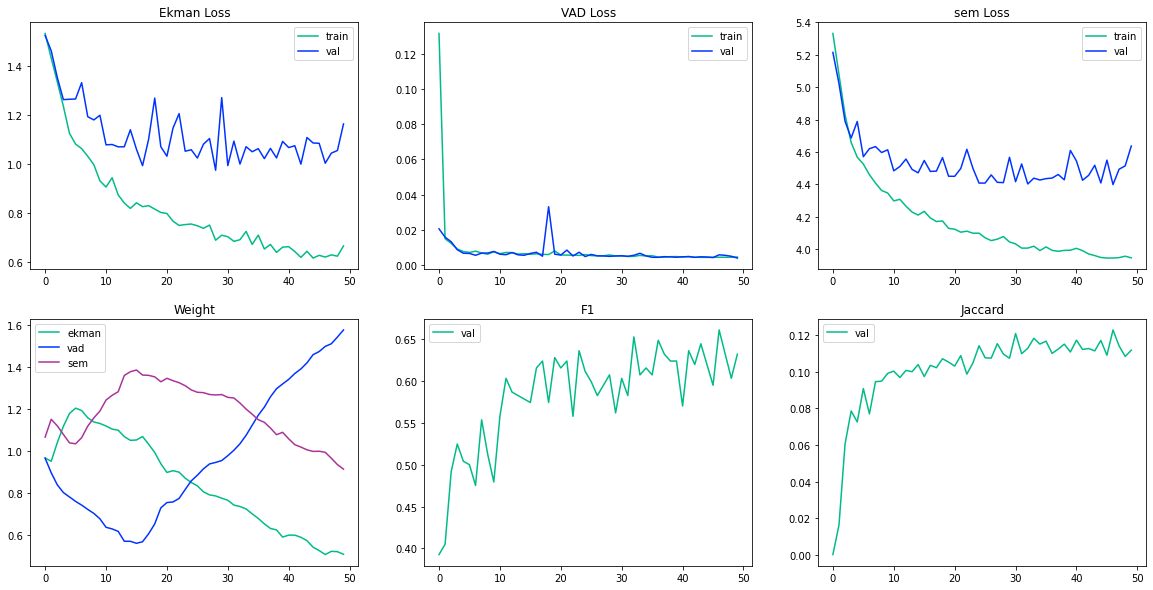

In [ ]:
exp.plot_history()

## Combined, network=256, dropout=0.5, w/ gradNorm, a=1

In [66]:
%%capture experiment
summary = Results_Summary()

config = {
    "dataset": "combined",
    "val_dataset": "combined",
    "gradNorm": True,
    "alpha": 1.0,
    "dropout": 0.5,
    'h_size': 256,
    'weight_decay': 1e-5,
}

for i in range(1):
  run = wandb.init(project="MultiEmo", name=f'Experiment{i+1}', config=config)

  exp2 = TrainingManager(dataloaders, config)
  exp2.train(epochs=10, log=True)

  losses, f1, mse, jaccard = exp2._evaluate(dataloaders['combined']['test'])
  test_results = {'ekman_loss': losses[0], 'vad_loss': losses[1], 'sem_loss': losses[2], 'loss': losses.sum(), 'f1': f1, 'jaccard': jaccard}
  
  for k, v in test_results.items():
    wandb.summary[k+'_test'] = v

  summary.add_history(exp2.history)
  summary.add_test_results(test_results)

  run.finish


AttributeError: ignored

In [68]:
run.finish()

AttributeError: ignored

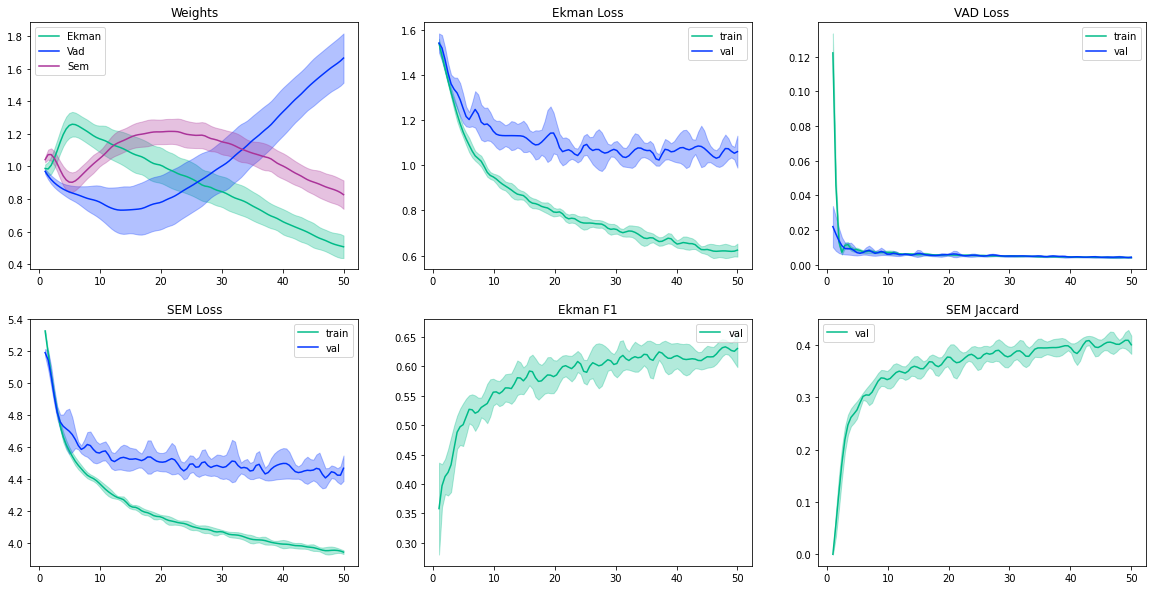

In [ ]:
summary.plot()

In [ ]:
summary.summary()

Ekman Loss: 0.640 +- 0.037
VAD Loss: 0.004 +- 0.000
sem Loss: 4.117 +- 0.072
Avg Loss: 4.760 +- 0.104
Avg F1: 0.767 +- 0.018
Avg Jaccard: 0.417 +- 0.020


## Combined, network=256, dropout=0.5, w/o gradNorm

In [ ]:
%%capture experiment
summary2 = Results_Summary()
for _ in tqdm(range(10)):
  net = MultiheadNetwork(dropout=0.5)
  net.to(DEVICE)

  exp3 = TrainingManager(net, dataloaders, with_gradNorm=False)
  exp3.train(epochs=50, train_label='combined', val_label='combined')

  # evaluate on test set
  losses, f1, mse, jaccard = exp3._evaluate(dataloaders['combined']['test'])
  # append results
  test_results = {'ekman_loss': losses[0], 'vad_loss': losses[1], 'sem_loss': losses[2], 'loss': losses.sum(), 'f1': f1, 'jaccard': jaccard}
  summary2.add_history(exp3.history)
  summary2.add_test_results(test_results)

  0%|          | 0/10 [00:00<?, ?it/s]

UsageError: Line magic function `%%capture` not found.


In [ ]:
summary2.plot()